### Classifier with w2v vectors

Vectorized on train data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics  import f1_score,accuracy_score
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import cross_validate
from sklearn import svm
import keras
from sklearn.preprocessing import OneHotEncoder
import pickle
import sys

Using TensorFlow backend.


In [2]:
train_set = pd.read_csv("dataset_train_pp.csv")
test_set = pd.read_csv("dataset_test_pp.csv")

In [3]:
print(len(train_set))
print(len(test_set))

50000
5000


In [4]:
train_x=train_set["Description"]
test_x=test_set["Description"]

train_y=train_set["Class Index"]
test_y=test_set["Class Index"]

In [5]:
%%time
test_x_vectors = np.load("w2v_test_x_300.npy")

CPU times: user 0 ns, sys: 7.6 ms, total: 7.6 ms
Wall time: 15.2 ms


In [6]:
%%time
train_x_vectors = np.load("w2v_train_x_300.npy")

CPU times: user 3.54 ms, sys: 48.5 ms, total: 52 ms
Wall time: 49.2 ms


In [7]:
# plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='confusion_matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], 
                horizontalalignment='center', 
                color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Naive Bays

In [16]:
naive_bays = MultinomialNB()

In [17]:
%%time
naive_bays.fit(train_x_vectors, train_y)

CPU times: user 166 ms, sys: 107 ms, total: 273 ms
Wall time: 164 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [18]:
p = pickle.dumps(naive_bays)
memoryKB = sys.getsizeof(p)/1000
print(memoryKB)

24.749


In [19]:
%%time
nb_pred_x = naive_bays.predict(test_x_vectors)

CPU times: user 24.1 ms, sys: 6.73 ms, total: 30.9 ms
Wall time: 18.8 ms


In [20]:
accuracy_score(test_y,nb_pred_x)

0.728

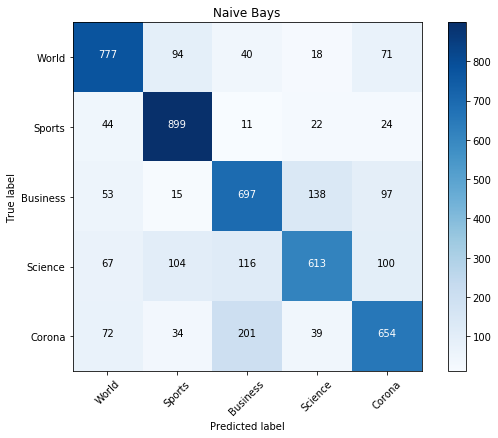

In [21]:
nb_cm = confusion_matrix(test_y, nb_pred_x)
cmPlotLabels = ['World', 'Sports', 'Business', 'Science', 'Corona']
plot_confusion_matrix(nb_cm, cmPlotLabels, title='Naive Bays')

### SVM

In [23]:
svm_model = svm.SVC(kernel='poly', degree=2, gamma='scale')

In [24]:
%%time
svm_model.fit(train_x_vectors, train_y)
# svm_model.fit(test_x_vectors, test_y) for speed test

CPU times: user 9min 8s, sys: 3.58 s, total: 9min 12s
Wall time: 9min 12s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [25]:
p = pickle.dumps(svm_model)
memoryKB = sys.getsizeof(p)/1000
print(memoryKB)

41345.383


In [26]:
%%time
svm_pred_x = svm_model.predict(test_x_vectors)

CPU times: user 56.7 s, sys: 55.8 ms, total: 56.8 s
Wall time: 56.9 s


In [27]:
accuracy_score(test_y,svm_pred_x)

0.8824

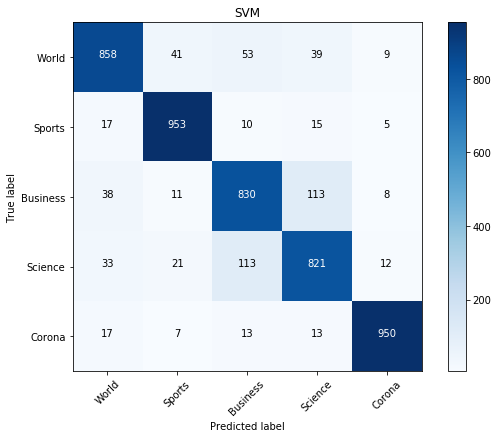

In [28]:
svm_cm = confusion_matrix(test_y, svm_pred_x)
plot_confusion_matrix(svm_cm, cmPlotLabels, title='SVM')

https://stackoverflow.com/questions/10592605/save-classifier-to-disk-in-scikit-learn

### NN

#### Prepare labels for keras

In [8]:
enc = OneHotEncoder(handle_unknown='ignore')

In [9]:
test_y_array = test_y.to_numpy().reshape(-1,1)
train_y_array = train_y.to_numpy().reshape(-1,1)

In [10]:
enc.fit(test_y_array)
test_y_1hot = enc.transform(test_y_array).toarray()

In [11]:
enc.fit(train_y_array)
train_y_1hot = enc.transform(train_y_array).toarray()

#### keras model

In [13]:
nn_model = None
nn_model = keras.models.Sequential()
nn_model.add(keras.layers.Dense(32, input_dim=300, activation='relu'))
nn_model.add(keras.layers.Dense(16, activation='relu'))
nn_model.add(keras.layers.Dense(16, activation='relu'))
nn_model.add(keras.layers.Dense(5, activation='softmax'))

In [14]:
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                9632      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 85        
Total params: 10,517
Trainable params: 10,517
Non-trainable params: 0
_________________________________________________________________


In [16]:
nn_model.compile(keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
%%time
nn_model.fit(train_x_vectors, train_y_1hot, epochs=30, batch_size=10)

W0618 16:10:19.414411 140021943641856 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0618 16:10:19.554638 140021943641856 deprecation_wrapper.py:119] From /home/amirhossein/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/30
50000/50000 [==============================] - 15s 309us/step - loss: 0.6199 - acc: 0.7755
Epoch 2/30
50000/50000 [==============================] - 14s 288us/step - loss: 0.4863 - acc: 0.8300
Epoch 3/30
50000/50000 [==============================] - 14s 289us/step - loss: 0.4635 - acc: 0.8380
Epoch 4/30
50000/50000 [==============================] - 15s 291us/step - loss: 0.4493 - acc: 0.8440
Epoch 5/30
50000/50000 [==============================] - 15s 293us/step - loss: 0.4377 - acc: 0.8466
Epoch 6/30
50000/50000 [==============================] - 15s 304us/step - loss: 0.4247 - acc: 0.8521
Epoch 7/30
50000/50000 [==============================] - 15s 295us/step - loss: 0.4156 - acc: 0.8538
Epoch 8/30
50000/50000 [==============================] - 15s 294us/step - loss: 0.4090 - acc: 0.8585
Epoch 9/30
50000/50000 [==============================] - 15s 299us/step - loss: 0.4028 - acc: 0.8600
Epoch 10/30
50000/50000 [==============================] - 15s 305us/step - loss: 

In [18]:
p = pickle.dumps(nn_model)
memoryKB = sys.getsizeof(p)/1000
print(memoryKB)

137.611


In [19]:
nn_model.evaluate(test_x_vectors, test_y_1hot, batch_size=10)

5000/5000 [==============================] - 1s 148us/step


[0.40598599456925877, 0.8687999956011773]

In [20]:
%%time
predictions = nn_model.predict(test_x_vectors)

CPU times: user 224 ms, sys: 3.05 ms, total: 227 ms
Wall time: 187 ms


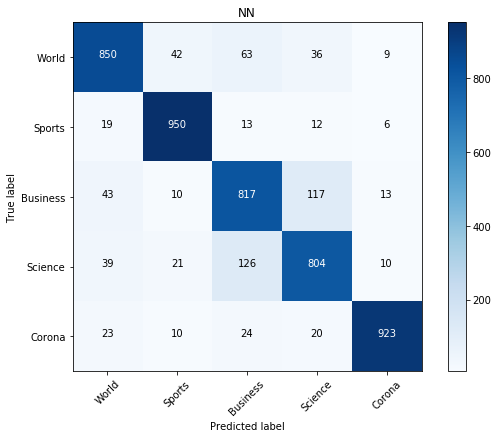

In [22]:
nn_cm = confusion_matrix(test_y, predictions.argmax(axis=1)+1)
cmPlotLabels = ['World', 'Sports', 'Business', 'Science', 'Corona']
plot_confusion_matrix(nn_cm, cmPlotLabels, title='NN')

In [23]:
nn_model.save("nn_w2v_300.h5")